# Sparse Matrices in Julia

Julia supports sparse matrices in the `SparseMatrixCSC` type. It uses
the CSC format, and the datatype `Tv` for the non-zeros and all indices `Ti`
can optionally be specified, `SparseMatrixCSC{Tv,Ti}`.

Some special sparse matrices can be created using the following functions (together with
their dense equivalents):

| Sparse             | Dense           | Description                                    |
|:------------------ |:--------------- |:---------------------------------------------- |
| `spzeros(m,n)`     | `zeros(m,n)`    | m-by-n matrix of zeros                         |
| `sparse(I, n, n)`  | `Matrix(I,n,n)` | n-by-n identity matrix                         |
| `Array(S)`         | `sparse(A)`     | Interconverts between dense and sparse formats |
| `sprand(m,n,d)`    | `rand(m,n)`     | m-by-n random matrix (uniform) of density d    |
| `sprandn(m,n,d)`   | `randn(m,n)`    | m-by-n random matrix (normal) of density d     |

More general sparse matrices can be created with the syntax `A = sparse(rows,cols,vals)` which
takes a vector `rows` of row indices, a vector `cols` of column indices,
and a vector `vals` of stored values (essentially the COO format).

The inverse of this syntax is `rows,cols,vals = findnz(A)`.

The number of non-zeros of a matrix `A` are returned by the `nnz(A)` function.

## Example

For the matrix considered above, the easiest approach is to start from the COO format
and use `sparse(rows, cols, vals)`. The size of the matrix is determined from the
indices, if needed it can also be specified as `sparse(rows, cols, vals, m, n)`.

In [1]:
using PyPlot, SparseArrays, LinearAlgebra # Packages used

In [2]:
rows = [1,3,4,2,1,3,1,4,1,5]
cols = [1,1,1,2,3,3,4,4,5,5]
vals = [5,-2,-4,5,-3,-1,-2,-10,7,9]

A = sparse(rows, cols, vals, 5, 5)

5×5 SparseMatrixCSC{Int64, Int64} with 10 stored entries:
  5  ⋅  -3   -2  7
  ⋅  5   ⋅    ⋅  ⋅
 -2  ⋅  -1    ⋅  ⋅
 -4  ⋅   ⋅  -10  ⋅
  ⋅  ⋅   ⋅    ⋅  9

We note that Julia only displays the non-zeros in the matrix. If needed, it can be converted
to a dense matrix:

In [3]:
Array(A)

5×5 Matrix{Int64}:
  5  0  -3   -2  7
  0  5   0    0  0
 -2  0  -1    0  0
 -4  0   0  -10  0
  0  0   0    0  9

But in many cases, it is enough to only show the *sparsity pattern* of the matrix
(not the actual values). PyPlot can visualize this using a so-called spy plot:

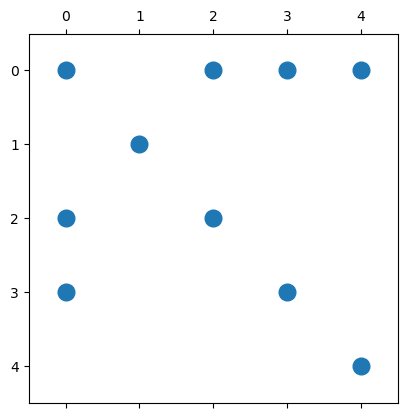

In [4]:
spy(A, marker=".", markersize=24);   ## Note - 0-based row and columns

## Operations on sparse matrices

Many operations work exactly the same for sparse matrices as for dense matrices,
including arithmetic operations, indexing, assignment, and concatenation:

In [5]:
B = A  - 4.3A   # Will automatically convert datatype of values to Float64
B[:,4] .= -1.1  # OK since B now has Float64 values (otherwise use Float64.(A) to convert)
C = A * A'      # Matrix multiplication (note: typically increases nnz)
Matrix([B C])   # Concatenation, again automatic conversion (of C)

5×10 Matrix{Float64}:
 -16.5    0.0  9.9  -1.1  -23.1  87.0   0.0  -7.0    0.0  63.0
   0.0  -16.5  0.0  -1.1    0.0   0.0  25.0   0.0    0.0   0.0
   6.6    0.0  3.3  -1.1    0.0  -7.0   0.0   5.0    8.0   0.0
  13.2    0.0  0.0  -1.1    0.0   0.0   0.0   8.0  116.0   0.0
   0.0    0.0  0.0  -1.1  -29.7  63.0   0.0   0.0    0.0  81.0

However, note that some standard operations can make the matrix more dense, and it might
not make sense to use a sparse storage format for the result. Also, inserting new elements
is expensive (for example the operation on the 4th column of `B` in the example above).

## Incremental matrix construction

Since Julia uses the CSC format for sparse matrices, it is inefficient to create
matrices incrementally (that is, to insert new non-zeros into the matrix).
As an example, consider building a matrix using a for-loop. We start with an empty
sparse matrix of given size $N$-by-$N$, and insert a total of $10N$ new random entries
at random positions.

In [6]:
"""
Incremental matrix construction using the sparse-format
Not recommended: Insertion into existing matrix very slow
"""
function incremental_test_1(N)
    A = spzeros(N,N)
    for k = 1:10N
        i,j = rand(1:N, 2)
        A[i,j] = rand()
    end
    return A
end

incremental_test_1

We time the function for increasing values of $N$:

In [7]:
incremental_test_1(10);   # Force compile before timing
for N in [100,1000,10000]
  @time incremental_test_1(N);
end

  0.000244 seconds (1.01 k allocations: 122.719 KiB)
  0.010900 seconds (10.02 k allocations: 1.409 MiB)
  1.374354 seconds (100.02 k allocations: 11.361 MiB)


We can observe the approximately *quadratic* dependency on $N$, even though the
number of non-zeros is only proportional to $N$. This is because of the inefficiencies
with element insertion into a sparse matrix.

Instead, we can build the same matrix using the COO format (row, column, and value indices)
and only call `sparse` ones:

In [8]:
"""
Incremental matrix construction using COO and a single call to sparse
Fast approach, avoids incremental insertion into existing array
"""
function incremental_test_2(N)
    rows = Int64[]
    cols = Int64[]
    vals = Float64[]
    for i = 1:10N
        push!(rows, rand(1:N))
        push!(cols, rand(1:N))
        push!(vals, rand())
    end
    return sparse(rows, cols, vals, N, N)
end

incremental_test_2

In [9]:
incremental_test_2(10);   # Force compile before timing
for N in [100,1000,10000,100000,1000000]
  @time incremental_test_2(N);
end

  0.000077 seconds (29 allocations: 99.547 KiB)
  0.001233 seconds (44 allocations: 1.285 MiB)
  0.013096 seconds (53 allocations: 8.764 MiB)
  0.216052 seconds (62 allocations: 62.151 MiB, 12.05% gc time)
  3.843811 seconds (682 allocations: 768.594 MiB, 6.99% gc time, 0.14% compilation time)


This version is magnitudes faster than the previous one, although it does not quite achieve
linear dependency on $N$ (possibly because of the sorting inside `sparse`).